In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import StrMethodFormatter, NullFormatter
leg_f=22
plt.rcParams["text.usetex"] =True
import numpy as np
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 30,'legend.fontsize':26})
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

In [4]:
from config import get_from_config
from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple
from wigrad import Wiggler, WigglerRadiationSimulator
lmda1 = 0.532
config_style_mesh = [
        [
            -0.0254,
            0.0254,
            512
        ],
        [
            -0.0254,
            0.0254,
            512
        ],
        [
            lmda1-0.01,
            lmda1+0.01,
            200
        ]
    ]
wiggler = Wiggler(K_peak=5.7, N_periods=22.5, lambda_wiggler_m=0.1)
rad_mesh_tuple = get_rad_mesh_tuple(config_style_mesh=config_style_mesh, zobs_in=3.5) 
x1d, y1d, l1d = rad_mesh_tuple
nx, ny, nl = [len(v) for v in rad_mesh_tuple]
def get_step(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)
dx, dy, dl = [get_step(v) for v in rad_mesh_tuple]
mesh = (rad_mesh_tuple[0][int(len(rad_mesh_tuple[0])/2):],
        rad_mesh_tuple[1][int(len(rad_mesh_tuple[1])/2):],
        rad_mesh_tuple[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=650/0.511,
    harmonics=[1],
    aperture='ellipse',
    # if False, then both polarizations are calculated separately
    only_calc_sum_of_both_polarizations=True,
    spectral_transmission=None
)
wr_sim.calc_photon_flux_on_meshgrid()
wr_sim.extend_results_using_symmetries()

In [5]:
sts = 0.0032/2.355
spectral_transmission = np.exp(-1/2/sts**2*(l1d-lmda1)**2)

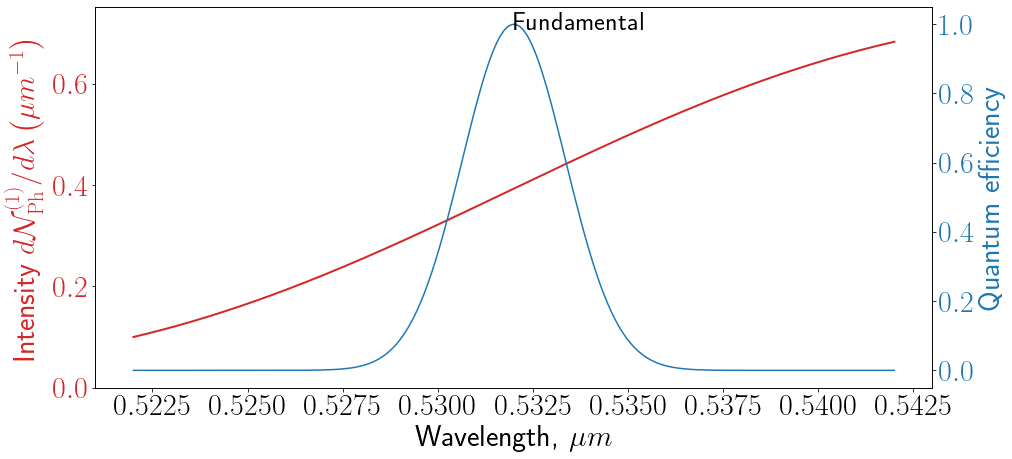

In [6]:
fig,ax = plt.subplots(figsize=[15,7])
ax.set_xlabel('Wavelength, $\mu m$')
color = 'tab:red'
sd = wr_sim.get_spectral_distribution()
plt.plot(l1d, sd, linewidth=2,color = color)
ax.set_ylabel(r'Intensity $d\mathcal{N}^{(1)}_{\mathrm{Ph}}/d\lambda \left(\mu m^{-1}\right)$', color=color)
plt.tick_params(axis ='y',labelcolor=color) 
plt.ylim(0,1.1*max(sd))
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Quantum efficiency', color=color)  # we already handled the x-label with ax1
ax2.plot(
    l1d,
    np.where(spectral_transmission>0, spectral_transmission, np.nan),
    color=color)
ax2.tick_params(axis='y', labelcolor=color)
align_yaxis(ax, 0, ax2, 0)
plt.text(0.5,0.94,'Fundamental',fontsize=26,transform=ax.transAxes)
plt.show()

In [7]:
i3d = spectral_transmission[:, None, None]*wr_sim.get_photon_flux_3D()
tot = dx*dy*dl*np.sum(i3d)
x1_2D, x2_2D = np.meshgrid(x1d, x1d)
x1m2_2d = x1_2D-x2_2D
y1_2D, y2_2D = np.meshgrid(y1d, y1d)
y1m2_2d = y1_2D-y2_2D

In [8]:
def get_Mxy(sx, sy):
    res = 0
    for slice2d, lmda in zip(i3d, l1d):
        Eexpx = np.tensordot(slice2d, lmda*np.exp(-(sx*2*np.pi/lmda*x1m2_2d)**2), (1,0))
        Eexpy = np.tensordot(slice2d, lmda*np.exp(-(sy*2*np.pi/lmda*y1m2_2d)**2), (0,1))
        res += np.tensordot(Eexpx, Eexpy.T)
    return tot**2/(dx*dy*dx*dy*dl*1/(2*np.sqrt(np.pi)*1e4)*res)

In [9]:
sx,sy = 1000, 320
c = 3e8  # m/s
sz = c*0.48e-9/2.355*100
Mt = sz*get_Mxy(sx, sy)
print(f"{Mt:.1e}")

5.7e+04


In [10]:
sx,sy = 960, 360
c = 3e8  # m/s
sz = c*0.48e-9/2.355*100
Ml = sz*get_Mxy(sx, sy)
print(f"{Ml:.1e}")

6.0e+04


In [11]:
ibeam = 50  # mA
N_av = 0.78*tot*ibeam*170.2e-9/1000/get_from_config("e")
print(f"{N_av:.2e}")

5.55e+07


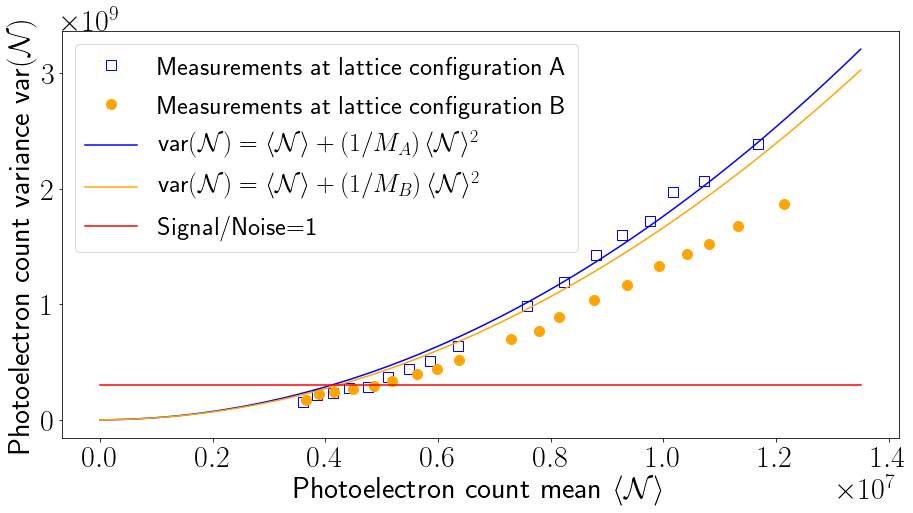

In [20]:
import csv
wt_x=[]
wt_y=[]
with open('bnl_data/variance_tight_beam.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in list(readCSV)[6:]:
        wt_x.append(float(row[0]))
        wt_y.append(float(row[1]))
        
wl_x=[]
wl_y=[]
with open('bnl_data/variance_unfocused_beam.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in list(readCSV)[6:]:
        wl_x.append(float(row[0]))
        wl_y.append(float(row[1]))
        
        
    
plt.rcParams.update({'font.size': 30,'legend.fontsize':26})
fig,ax = plt.subplots()
s=10
ax.plot(wt_x,wt_y,'ks-',markersize=s,color='b', markerfacecolor='none',linestyle='None',label = 'Measurements at lattice configuration A')
ax.plot(wl_x,wl_y,'o',markersize=s,color='orange',
label='Measurements at lattice configuration B')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

muW = 1
noise_lev = 3e8
min_x = 0.0e7
max_x=1.35e7
xx = np.linspace(min_x,max_x,1000)

ax.plot(xx,[muW*m+1/Mt*m**2 for m in xx],color='blue',
label=r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{A}\right)\langle\mathcal{N}\rangle^2$")
ax.plot(xx,[muW*m+1/Ml*m**2 for m in xx],color='orange',
label=r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{B}\right)\langle\mathcal{N}\rangle^2$")
plt.ylabel(r'Photoelectron count variance var$(\mathcal{N})$')
plt.xlabel(r'Photoelectron count mean $\langle\mathcal{N}\rangle$')
plt.plot([min_x,max_x],[noise_lev,noise_lev],color='red',label = 'Signal/Noise=1')

ax.legend( loc=2,prop = {'size':26})



plt.savefig("/home/ilobach/PRAB_fluctuations_theory/images/bnl_data.png",dpi=300, bbox_inches='tight')

plt.show()
plt.close(fig)